# Merging SRTM Tiles into a GeoTiff with RasterIO

## 1. Get the raster tiles

In [4]:
import os
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import matplotlib.pyplot as plt

import utils

srtm_tiles = [
  'N27E086.hgt',
  'N27E087.hgt',
  'N28E086.hgt',
  'N28E087.hgt'
]

data_url = 'https://github.com/spatialthoughts/python-dataviz-web/raw/main/data/srtm/'

for tile in srtm_tiles:
  url = '{}/{}'.format(data_url, tile)
  utils.download(url)

Downloaded data/N27E086.hgt
Downloaded data/N27E087.hgt
Downloaded data/N28E086.hgt
Downloaded data/N28E087.hgt


## 2. Explore the tile contents

In [5]:
filename = 'N28E087.hgt'
file_path = os.path.join(utils.data_folder, filename)
rds = rxr.open_rasterio(file_path)

rds
rds.values
rds.coords

print('CRS:', rds.rio.crs)
print('Resolution:', rds.rio.resolution())
print('Bounds:', rds.rio.bounds())
print('Width:', rds.rio.width)
print('Height:', rds.rio.height)

band1 = rds.sel(band=1)
band1

CRS: EPSG:4326
Resolution: (0.0002777777777777778, -0.0002777777777777778)
Bounds: (86.99986111111112, 27.999861111111112, 88.00013888888888, 29.000138888888888)
Width: 3601
Height: 3601


<xarray.DataArray (y: 3601, x: 3601)>
array([[5217, 5211, 5208, ..., 5097, 5098, 5089],
       [5206, 5201, 5200, ..., 5080, 5075, 5069],
       [5199, 5194, 5191, ..., 5063, 5055, 5048],
       ...,
       [5347, 5345, 5343, ..., 5747, 5750, 5757],
       [5338, 5338, 5336, ..., 5737, 5740, 5747],
       [5332, 5331, 5332, ..., 5734, 5736, 5744]], dtype=int16)
Coordinates:
    band         int64 1
  * x            (x) float64 87.0 87.0 87.0 87.0 87.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 29.0 29.0 29.0 29.0 29.0 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0
    units:          m

## 3. Plot all of the raster tiles

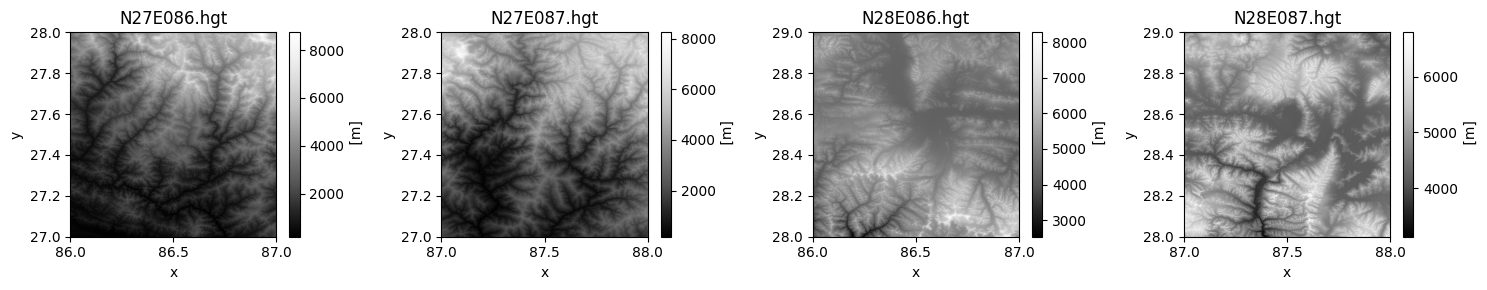

In [6]:
datasets = []
for tile in srtm_tiles:
    path = os.path.join(utils.data_folder, tile)
    rds = rxr.open_rasterio(path)
    band = rds.sel(band=1)
    datasets.append(band)

# Create the plot
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,3)
for index, ax in enumerate(axes.flat):
    da = datasets[index]
    im = da.plot.imshow(ax=ax, cmap='Greys_r')
    filename = srtm_tiles[index]
    ax.set_title(filename)

plt.tight_layout()
plt.show()

## 4. Use XArray to merge the tiles into a GeoTiff

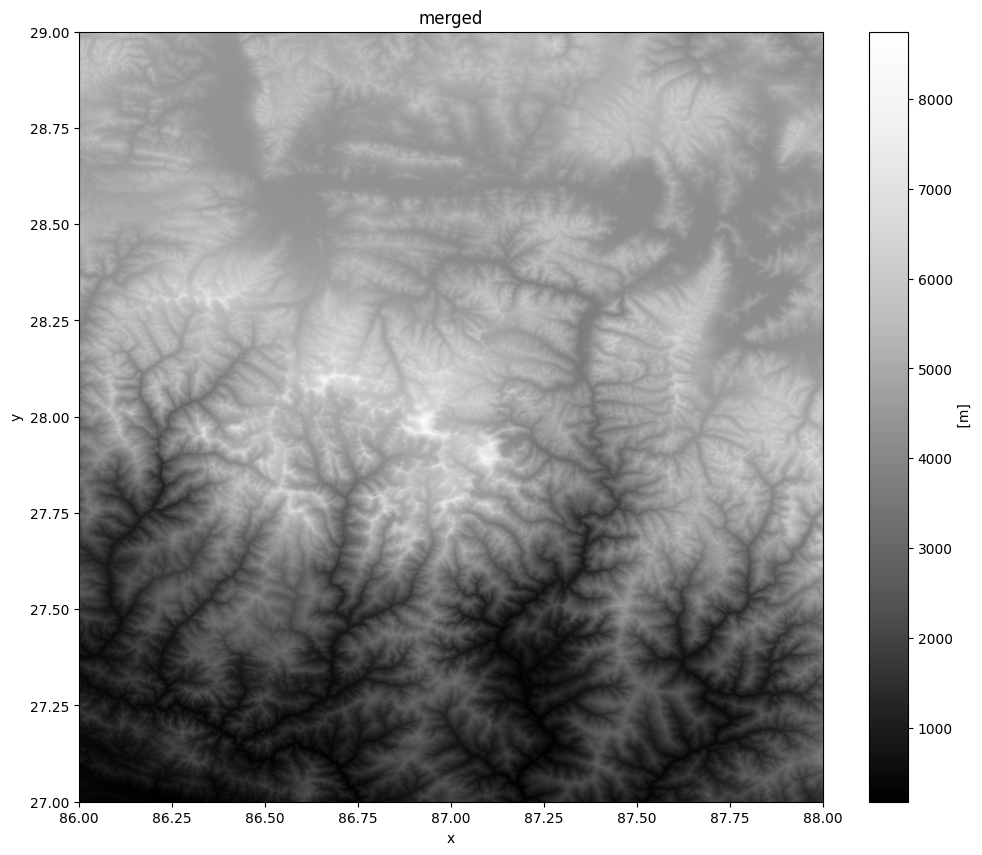

In [7]:
merged = merge_arrays(datasets, method='first')

# Confirm it worked
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
merged.plot.imshow(ax=ax, cmap='Greys_r')
ax.set_title('merged')
plt.show()

## 5. Find Everest (highest point) and annotate the image

86.92555555555556 27.988888888888887 8748


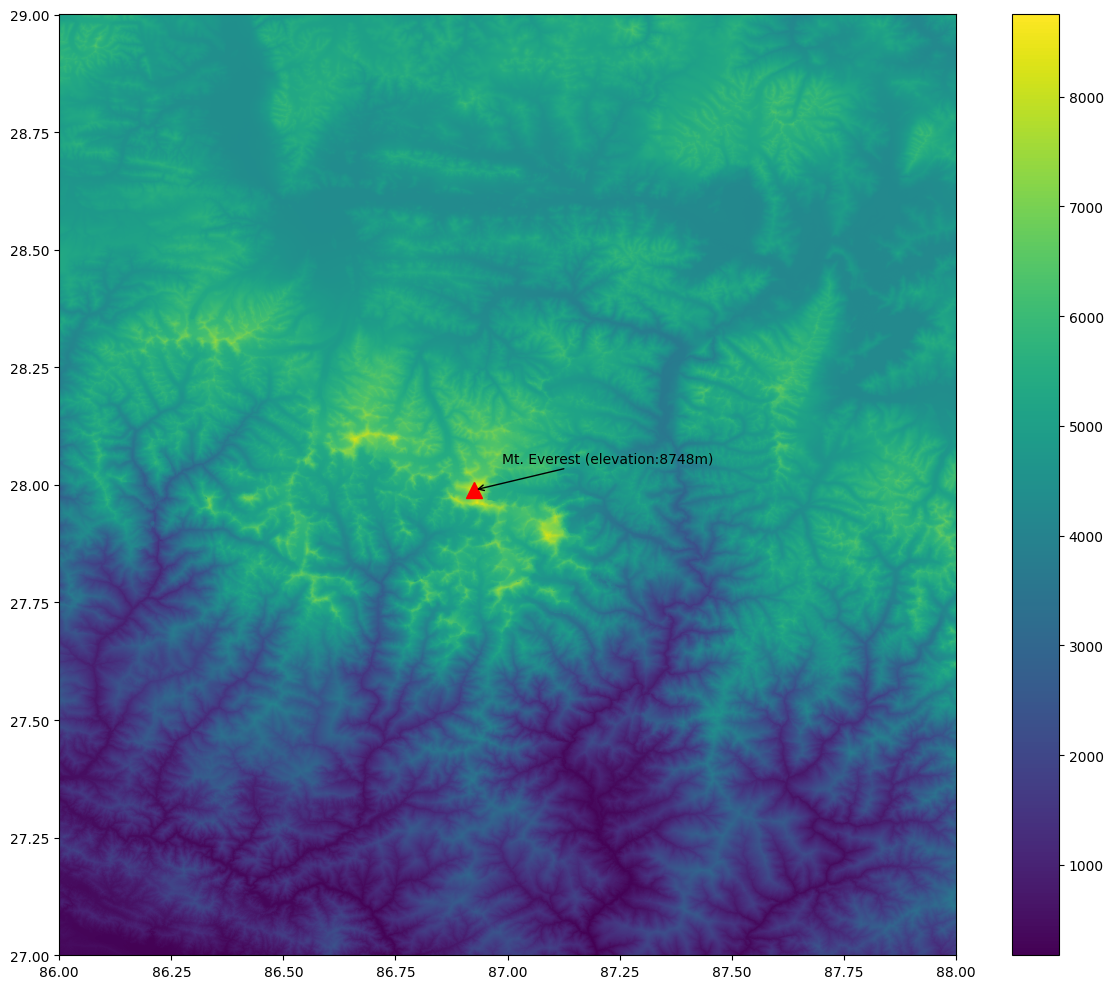

In [10]:
# Find the max elevation and get those coordinates
max_da = merged.where(merged==merged.max(), drop=True).squeeze()
max_x = max_da.x.values
max_y = max_da.y.values
max_elev = int(max_da.values)
print(max_x, max_y, max_elev)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 10)
merged.plot.imshow(ax=ax, cmap='viridis', add_labels=False)
ax.plot(max_x, max_y, '^r', markersize=11)
ax.annotate('Mt. Everest (elevation:{}m)'.format(max_elev),
            xy=(max_x, max_y), xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black')
            )
plt.tight_layout()
plt.show()

output_filename = 'merged.tif'
output_path = os.path.join(utils.results_folder, output_filename)
merged.rio.to_raster(output_path)

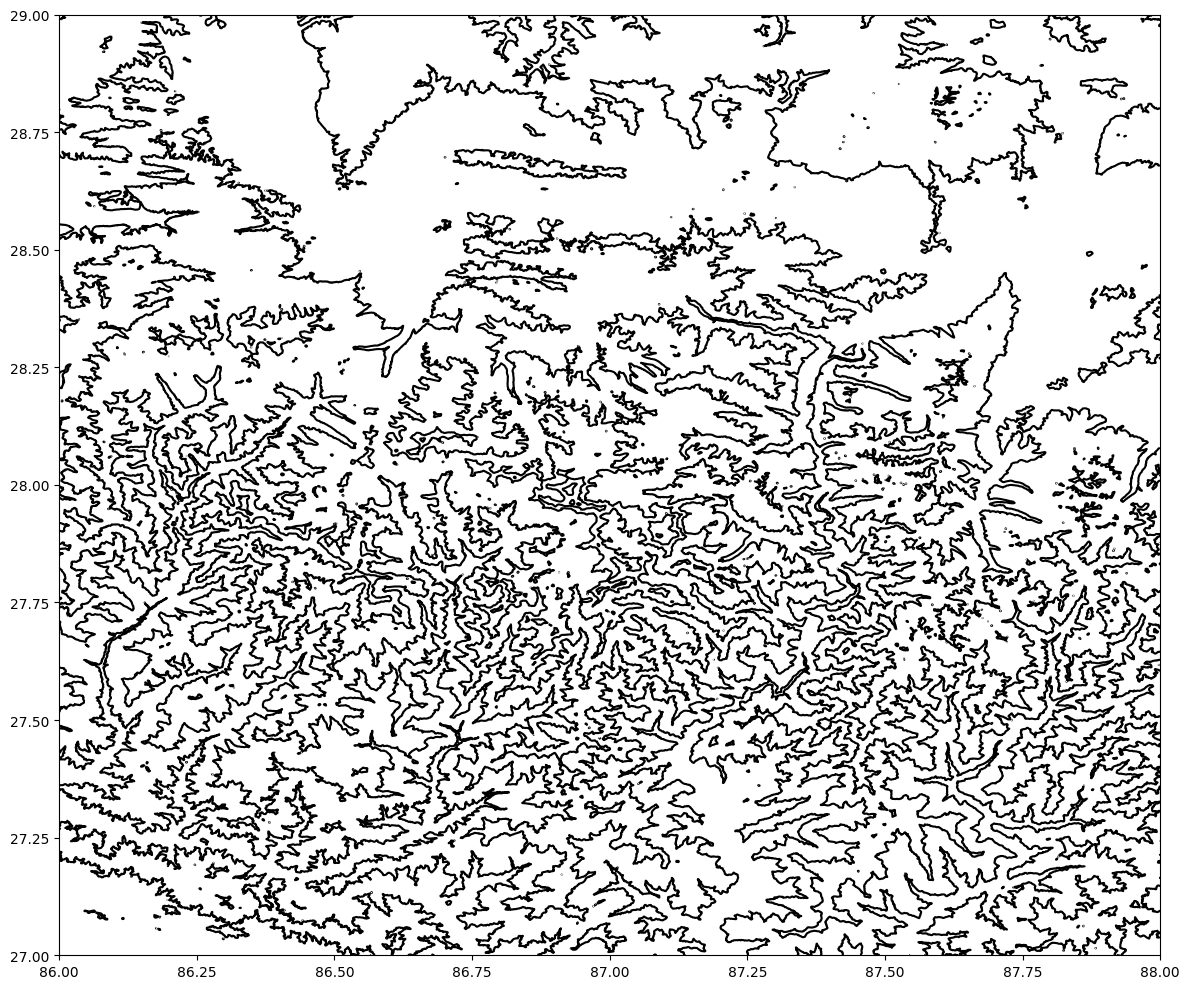

In [19]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 10)
merged.plot.contour(ax=ax, add_labels=False, colors='black', levels=10)
plt.tight_layout()
plt.show()